# Deep learning tricks with Pytorch Lightning

## Model checkpointing and early stopping

`model checkpointing`: saving a model's weights during training
`early stopping`: stopping training when the model performance stops improving

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import lightning as L
import torchmetrics
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt



# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, feature_array, label_array, transform = None):
        self.x = feature_array
        self.y = label_array
        self.transform = transform
    
    def __getitem__(self, index): # Returns a tuple of (image, label)
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.y)

# Create dummy classification data using sklearn.datasets.make_classification
class CustomDataModule(L.LightningDataModule):
    def __init__(self, data_dir = "./mnist", batch_size = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self): # Operations to do on 1 GPU e.g. download
        pass

    def setup(self, stage: str):
        # Operations to do on all GPUs e.g split
        X, y = make_classification(
        n_samples=20000,
        n_features=100,
        n_informative=10,
        n_redundant=40,
        n_repeated=25,
        n_clusters_per_class=5,
        flip_y=0.05,
        class_sep=0.5,
        random_state=123
        )
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
        # Split train set into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=123)

        # Convert data to datasets
        self.train_dataset = CustomDataset(
            X_train.astype(np.float32), y_train.astype(np.int64)
        )

        self.val_dataset = CustomDataset(
            X_val.astype(np.float32), y_val.astype(np.int64)
        )

        self.test_dataset = CustomDataset(
            X_test.astype(np.float32), y_test.astype(np.int64)
        )

    def train_dataloader(self):
        train_dl = DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 0,
        )
        return train_dl
    
    def val_dataloader(self):
        val_dl = DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0,
        )
        return val_dl
    
    def test_dataloader(self):
        test_dl = DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0,
        )
        return test_dl

c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [6]:
dm = CustomDataModule()
dm.setup("train")
# Print size of train, validation and test sets
print(f"Training set size: {len(dm.train_dataset)}, \nValidation set size: {len(dm.val_dataset)}, \nTest set size: {len(dm.test_dataset)}")

Training set size: 14400, 
Validation set size: 1600, 
Test set size: 4000


### Check label distribution

In [17]:
from collections import Counter
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()

train_counter = Counter()
for features, labels in train_dl:
    train_counter.update(labels.tolist())

print(f"Train set class distribution: {sorted(train_counter.items())}")

val_counter = Counter()
for features, labels in val_dl:
    val_counter.update(labels.tolist())

print(f"Validation set class distribution: {sorted(val_counter.items())}")

test_counter = Counter()
for features, labels in test_dl:
    test_counter.update(labels.tolist())

print(f"Test set class distribution: {sorted(test_counter.items())}")



Train set class distribution: [(0, 7209), (1, 7191)]
Validation set class distribution: [(0, 791), (1, 809)]
Test set class distribution: [(0, 2027), (1, 1973)]


### Zero-rule baseline/Majority class classifier
Metrics if we predict the majority class for all samples

In [24]:
majority_class = test_counter.most_common(1)[0]
print(f"Majority class: {majority_class[0]}")

baseline_accuracy = majority_class[1] / sum(test_counter.values())
print(f"Baseline accuracy: {baseline_accuracy:.2f}")

Majority class: 0
Baseline accuracy: 0.51


### Model checkpointing

In [3]:
# Create a Pytorch model
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes)
        )

    # Foward the input through the model
    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        logits = self.all_layers(x)
        return logits

# Create a Pytorch Lightning module
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate

        # Log hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Set up metrics
        self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.val_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.test_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim = 1)
        return loss, predicted_labels, true_labels
    
    def training_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        # Log loss
        self.log("train_loss", loss)

        # Compute accuracy
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_step = False, on_epoch = True, prog_bar=True)
        return loss # Return loss to be used by optimizer
    
    def validation_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer


In [34]:
# Train the model
torch.manual_seed(123)
dm = CustomDataModule()

# Define Pytorch model
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)

# Define Pytorch Lightning model
lightning_model = LightningModel(model = pytorch_model, learning_rate = 0.05)

# Specify model checkpoint callback
from lightning.pytorch.callbacks import ModelCheckpoint # Callback that saves the best model based on some meteric

callbacks = [
    ModelCheckpoint(save_top_k = 1, monitor = "val_acc", mode = "max", save_last = True)
]

# Define training arguments
trainer = L.Trainer(
    callbacks = callbacks,
    max_epochs = 10,
    accelerator = "gpu",
    devices = "auto",
    logger = CSVLogger(save_dir = "./logs", name = "my_model"),
    deterministic = True,

)

# Train the model
trainer.fit(model = lightning_model, datamodule = dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 6.4 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


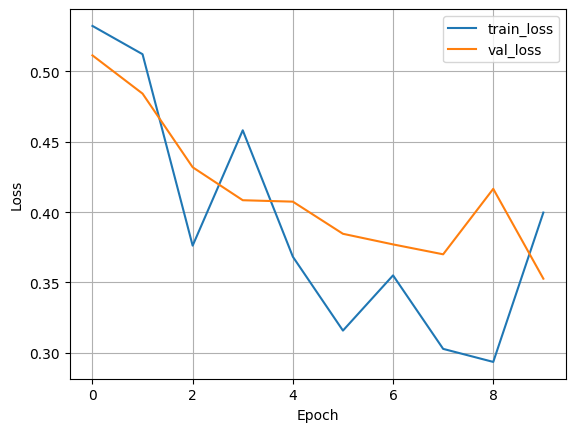

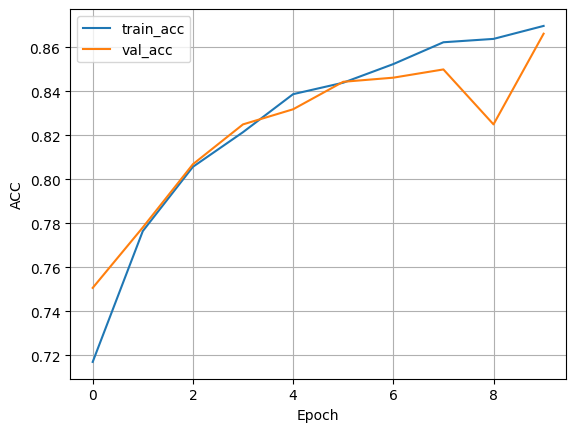

In [41]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

In [40]:
f"{trainer.logger.log_dir}/metrics.csv"

'./logs\\my_model\\version_1/metrics.csv'

### Comparing the best model and last saved model on test data

In [42]:
trainer.test(model = lightning_model, datamodule=dm, ckpt_path="best")
# trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path="best")

Restoring states from the checkpoint path at ./logs\my_model\version_1\checkpoints\epoch=9-step=4500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs\my_model\version_1\checkpoints\epoch=9-step=4500.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8529999852180481     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8529999852180481}]

In [44]:
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path="last")

Restoring states from the checkpoint path at c:\Users\homeuser\Documents\deep_learning_fundamentals\logs\my_model\version_1\checkpoints\last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\homeuser\Documents\deep_learning_fundamentals\logs\my_model\version_1\checkpoints\last.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8529999852180481     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8529999852180481}]

In [50]:
# Path where these models are saved
path = trainer.checkpoint_callback.best_model_path

print(path)

./logs\my_model\version_1\checkpoints\epoch=9-step=4500.ckpt


On new data:

In [48]:
lightning_model = LightningModel.load_from_checkpoint(
    checkpoint_path = path,
    model = pytorch_model,
)

# Put model in evaluation mode
lightning_model.eval()

trainer.test(model = lightning_model, datamodule = dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8529999852180481     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8529999852180481}]

## Learning rate and learning rate scheduler.

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

### Automatic learning rate finder

In [5]:
torch.manual_seed(123)
# Instantiate datamodule
dm = CustomDataModule()

# Instantiate Pytorch model
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)

# Instantiate Pytorch Lightning model
lightning_model = LightningModel(model = pytorch_model, learning_rate = 0.1)
##Now let's find an optimal learning rate

from lightning.pytorch.tuner import Tuner
# Import callback for model checkpointing
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k = 1, monitor = "val_acc", mode = "max", save_last = True)
]
# Set up training parameters
trainer = L.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "my_model"),
    deterministic = True,
    callbacks = callbacks,
)

# Set up tuner
tuner = Tuner(trainer)

# Find learning rate
lr_finder = tuner.lr_find(model = lightning_model, datamodule = dm)


New learning rate: 0.48


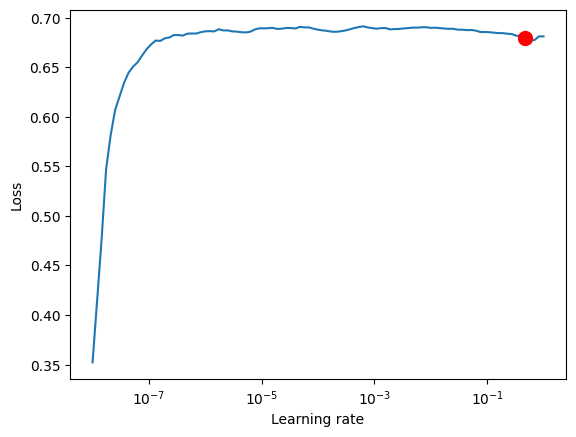

In [17]:
# Visualize learning rate
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(f"New learning rate: {new_lr:.2f}")

In [ ]:
# Update learning rate in the lightning model
lightning_model.learning_rate = 0.1

# Train the model
trainer.fit(model = lightning_model, datamodule = dm)

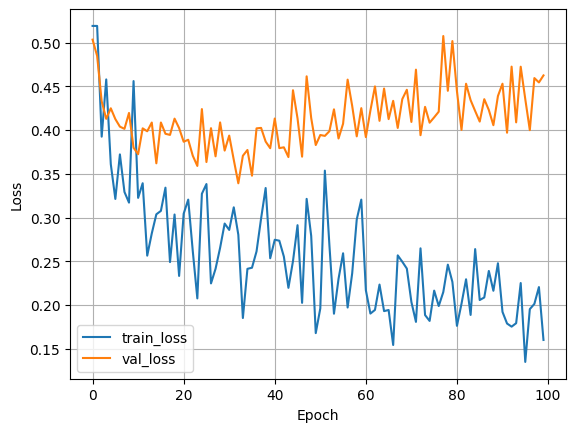

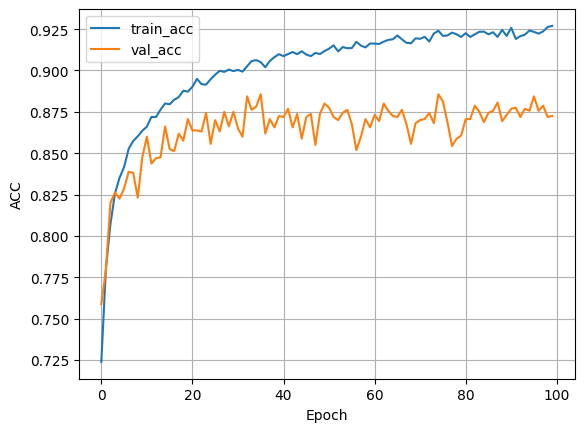

In [8]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

In [9]:
trainer.checkpoint_callback.best_model_path

'./logs\\my_model\\version_6\\checkpoints\\epoch=35-step=16200.ckpt'

In [11]:
# How the model performs on the test set
# Path to the best model
path = trainer.checkpoint_callback.best_model_path
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path=path)

Restoring states from the checkpoint path at ./logs\my_model\version_6\checkpoints\epoch=35-step=16200.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs\my_model\version_6\checkpoints\epoch=35-step=16200.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8715000152587891     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8715000152587891}]

# using lr finder: 'test_acc': 0.6937500238418579

### Learning rate schedulers

These are techniques used im machine learning to adjust the learning rate during the training process of a neural network. They help prevent issues like slow convergence, oscillations and divergence during training.

Recommendation: start without a scheduler first, then compare results with a scheduler.

#### StepLR
The learning rate is reduced by a factor `gamma` after a predefined number of training epochs.

In [ ]:
# Create a Pytorch model
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes)
        )

    # Foward the input through the model
    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        logits = self.all_layers(x)
        return logits

# Create a Pytorch Lightning module
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate

        # Log hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Set up metrics
        self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.val_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.test_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim = 1)
        return loss, predicted_labels, true_labels
    
    def training_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        # Log loss
        self.log("train_loss", loss)

        # Compute accuracy
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_step = False, on_epoch = True, prog_bar=True)
        return loss # Return loss to be used by optimizer
    
    def validation_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5) # Half the learning rate every 10 epochs
        return [optimizer], [scheduler]
    

torch.manual_seed(123)
# Instantiate datamodule
dm = CustomDataModule()

# Instantiate Pytorch model
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)

# Instantiate Pytorch Lightning model
lightning_model = LightningModel(model = pytorch_model, learning_rate = 0.1)
##Now let's find an optimal learning rate

from lightning.pytorch.tuner import Tuner
# Import callback for model checkpointing
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k = 1, monitor = "val_acc", mode = "max", save_last = True)
]
# Set up training parameters
trainer = L.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "step_lr"),
    deterministic = True,
    callbacks = callbacks,
)

# # Set up tuner
# tuner = Tuner(trainer)

# # Find learning rate
# lr_finder = tuner.lr_find(model = lightning_model, datamodule = dm)

# Train the model
trainer.fit(model = lightning_model, datamodule = dm)


In [4]:
path = trainer.checkpoint_callback.best_model_path
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path=path)

Restoring states from the checkpoint path at ./logs\step_lr\version_0\checkpoints\epoch=23-step=10800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs\step_lr\version_0\checkpoints\epoch=23-step=10800.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8755000233650208     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8755000233650208}]

better test accuracy than baseline: 0.8715000152587891

Let's visualize the learning rate scheduler

Text(0, 0.5, 'Learning rate')

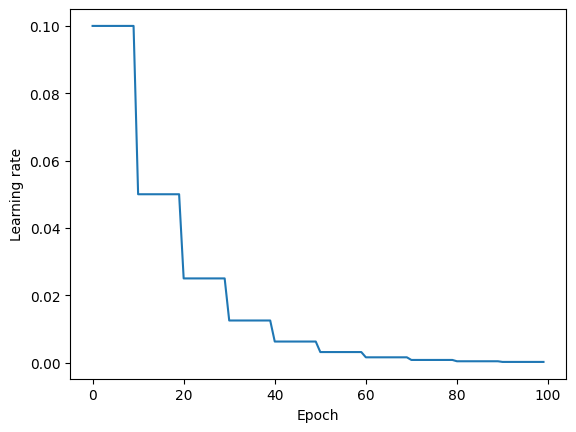

In [10]:
opt = torch.optim.SGD(pytorch_model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 10, gamma = 0.5)

lrs = []
max_epochs = 100

for epoch in range(max_epochs):
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])
    scheduler.step()


plt.plot(range(max_epochs), lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")

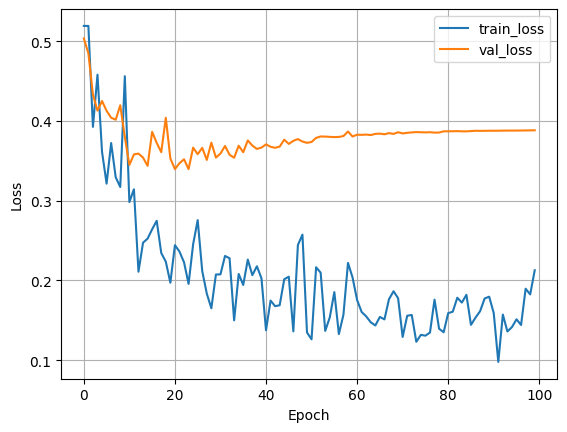

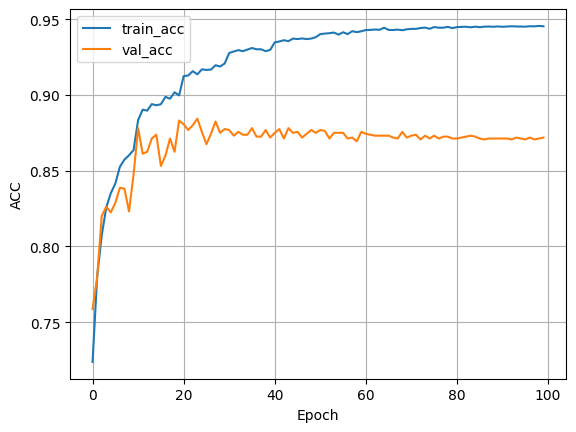

In [11]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

#### ReduceLROnPlateau
Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates.

In [ ]:
# Create a Pytorch model
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes)
        )

    # Foward the input through the model
    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        logits = self.all_layers(x)
        return logits

# Create a Pytorch Lightning module
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate

        # Log hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Set up metrics
        self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.val_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.test_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim = 1)
        return loss, predicted_labels, true_labels
    
    def training_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        # Log loss
        self.log("train_loss", loss)

        # Compute accuracy
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_step = False, on_epoch = True, prog_bar=True)
        return loss # Return loss to be used by optimizer
    
    def validation_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, factor=0.1, mode = "min")
        return{
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            }
        }
    

torch.manual_seed(123)
# Instantiate datamodule
dm = CustomDataModule()

# Instantiate Pytorch model
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)

# Instantiate Pytorch Lightning model
lightning_model = LightningModel(model = pytorch_model, learning_rate = 0.1)
##Now let's find an optimal learning rate

from lightning.pytorch.tuner import Tuner
# Import callback for model checkpointing
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k = 1, monitor = "val_acc", mode = "max", save_last = True)
]
# Set up training parameters
trainer = L.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "reduce_lr_plateau"),
    deterministic = True,
    callbacks = callbacks,
)

# # Set up tuner
# tuner = Tuner(trainer)

# # Find learning rate
# lr_finder = tuner.lr_find(model = lightning_model, datamodule = dm)

# Train the model
trainer.fit(model = lightning_model, datamodule = dm)


In [3]:
# Performance on test
path = trainer.checkpoint_callback.best_model_path
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path=path)

Restoring states from the checkpoint path at ./logs\reduce_lr_plateau\version_0\checkpoints\epoch=20-step=9450.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs\reduce_lr_plateau\version_0\checkpoints\epoch=20-step=9450.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8672500252723694     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8672500252723694}]

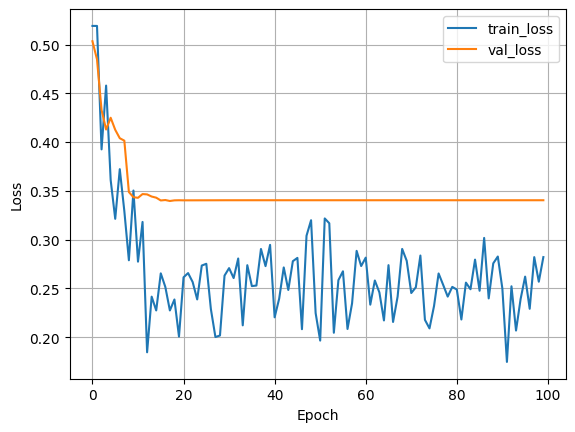

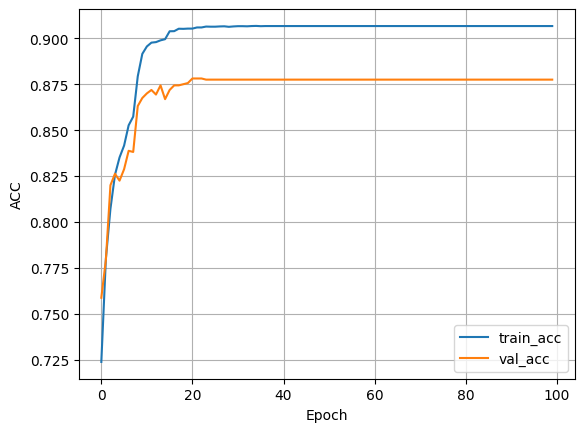

In [4]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

#### CosineAnnealingLR
The learning rate follows a cosine curve, decreasing then increasing over time.



##### Cosine annealing with restarts
The learning rate decreases following a cosine curve, but restarts after a number of epochs as shown below:

Text(0.5, 1.0, 'Cosine Annealing LR with restarts')

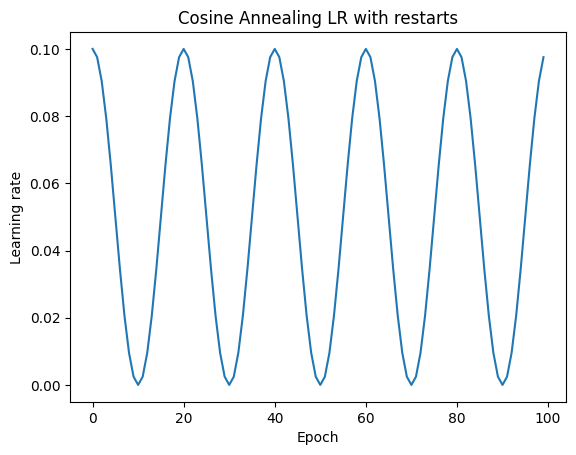

In [6]:
num_epochs = 100
optimizer = torch.optim.SGD(pytorch_model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, T_max = num_epochs/10)
lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(num_epochs), lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Cosine Annealing LR with restarts")

It's more popular to decay the learning rate over the whole schedule other than restarting it.

#### Cosine annealing with 1-cycle schedule - decay over each epoch

Text(0.5, 1.0, 'Cosine Annealing LR decay over each epoch')

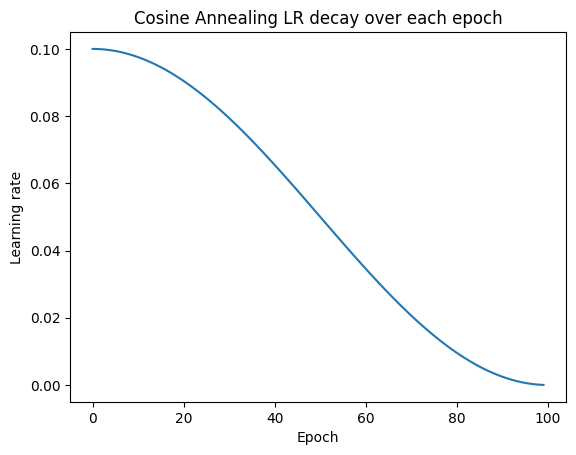

In [7]:
num_epochs = 100
optimizer = torch.optim.SGD(params=pytorch_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(num_epochs), lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Cosine Annealing LR decay over each epoch")

##### Cosine annealing with 1-cycle schedule - decay each batch

Text(0.5, 1.0, 'Cosine Annealing LR decay over each batch in the entire training')

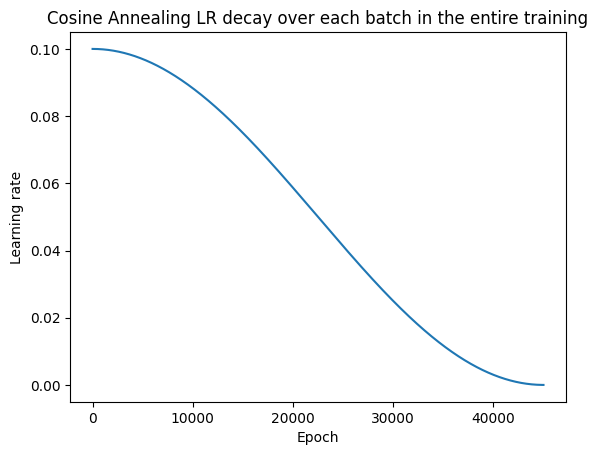

In [17]:
num_epochs = 100
dm = CustomDataModule()
dm.setup("train")
num_steps = num_epochs * len(dm.train_dataloader())
optimizer = torch.optim.SGD(params=pytorch_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_steps)
lrs = []

for i in range(num_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Cosine Annealing LR decay over each batch in the entire training")

This is a popular annealing schedule and is what we will use in this notebook.

In [ ]:
# Create a Pytorch model
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes)
        )

    # Foward the input through the model
    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        logits = self.all_layers(x)
        return logits

# Create a Pytorch Lightning module
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, cosine_tmax):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate
        self.cosine_tmax = cosine_tmax

        # Log hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Set up metrics
        self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.val_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.test_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim = 1)
        return loss, predicted_labels, true_labels
    
    def training_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        # Log loss
        self.log("train_loss", loss)

        # Compute accuracy
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_step = False, on_epoch = True, prog_bar=True)
        return loss # Return loss to be used by optimizer
    
    def validation_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = self.cosine_tmax)
        return{
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "interval": "epoch", # Decay learning rate after each step
                "frequency": 1,
            }
        }
    

torch.manual_seed(123)
num_epochs = 100
# Instantiate datamodule
dm = CustomDataModule()
# dm.setup("train")
# num_steps = len(dm.train_dataloader()) * 100
# dm = CustomDataModule()

# Instantiate Pytorch model
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)

# Instantiate Pytorch Lightning model
lightning_model = LightningModel(model = pytorch_model, learning_rate = 0.1, cosine_tmax = num_epochs)
##Now let's find an optimal learning rate

from lightning.pytorch.tuner import Tuner
# Import callback for model checkpointing
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k = 1, monitor = "val_acc", mode = "max", save_last = True)
]
# Set up training parameters
trainer = L.Trainer(
    max_epochs = num_epochs,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "cosine_annealing_lr"),
    deterministic = True,
    callbacks = callbacks,
)

# # Set up tuner
# tuner = Tuner(trainer)

# # Find learning rate
# lr_finder = tuner.lr_find(model = lightning_model, datamodule = dm)

# Train the model
trainer.fit(model = lightning_model, datamodule = dm)


In [3]:
path = trainer.checkpoint_callback.best_model_path
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path=path)

Restoring states from the checkpoint path at ./logs\cosine_annealing_lr\version_1\checkpoints\epoch=49-step=22500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs\cosine_annealing_lr\version_1\checkpoints\epoch=49-step=22500.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8867499828338623     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8867499828338623}]

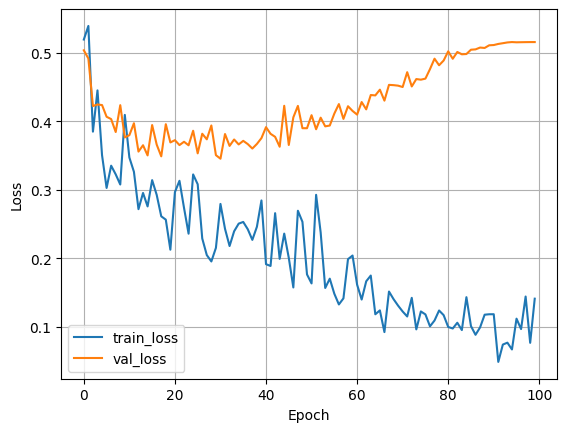

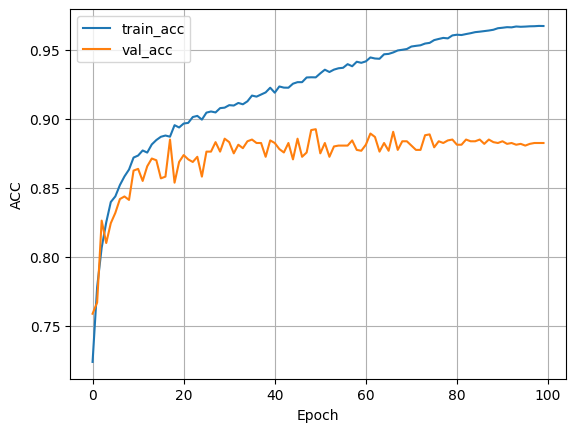

In [4]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

Massive overfitting but this will be fixed in the future.

## Using more advanced optimization algorithms

Some popular optimization algorithms are: `SGD with momentum`, `Adam`

`SGD with momentum` builds upon the basic idea of gradient descent but incorporates a momentum term to improve convergece and escape local minima. In regular gradient descent, the model parameters are updated by moving in the direction of the negative gradient of the loss function i.e
$$
\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)
$$
where $\theta$ is the model parameter, $\eta$ is the learning rate and $\nabla L(\theta_t)$ is the gradient of the loss function at $\theta_t$.

Stochastic gradient descent with momentum remembers the update Δw at each iteration, and determines the next update as a linear combination of the gradient and the previous update:
$$
\Delta w = \alpha \Delta w - \eta \nabla L(\theta_t) \\
w = w + \Delta w

$$
this leads to:
$$
w = w  - \eta \nabla L(\theta_t) + \alpha \Delta w\\
$$
where $\alpha$ is the momentum term. The momentum term $\alpha$ is usually set to 0.9 or a similar value. In SGD with momentum, you introduce a new concept: momentum. It's like adding inertia to the optimization process.
At each iteration, you accumulate a velocity term that is influenced by the previous gradients.

SGD with momentum helps to dampen oscillations and speed up convergence.

In PyTorch:
> optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)

*ADAM*: Adaptive Moment Estimation, works on the key idea of automatically adjusting the lr during training. Decreases the learning rate if gradient changes direction otherwise increases lr if gradient stays consistent. Can still benefit from LR scheduling.

$$
w = w - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}
$$

In PyTorch:
> optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Activation functions

Activation functions determine the output of a neuron. The choice of activation function depends on the problem one is trying to solve and background mathematical underpinnings. For instance, using a sigmoid activation function in the hidden layers of a neural network can cause the vanishing gradient problem. This is because the gradient of the sigmoid function is close to zero for most of its domain. A popular activation function for hidden layers is the `ReLU` function. However when used at the output layer, sigmoid and softmax are popular choices for binary and multi-class classification respectively.

Newer activation functions like `GELU`,`Swish` and `Mish` have been shown to perform better than ReLU in some cases. The following blog post provides a good overview of activation functions: https://www.v7labs.com/blog/neural-networks-activation-functions

## Hyperparameter tuning

- Grid search: manually define a grid of hyperparameter values and train a model for each combination. Choose the combination that results in the best performance.
-Random search: create a grid of randomly sampled hyperparameter values and train a model for each combination. Choose the combination that results in the best performance. We normally sample from a `log-uniform` distribution since most hyperparameter values like learning rates are usually small and vary like a log normal distribution.

## Batch normalization and dropout
Batch normalization is a technique used to **stabilize**, **accelerate training**, and **reduce overfitting** of neural networks by normalizing the inputs to each hidden layer within a mini-batch.

- Each hidden layer's inputs can have a wide range of values, especially during training as the weights are adjusted. This can lead to vanishing/exploding gradients slowing convergence. Batch normalization addresses this issue by re-scaling the inputs to have a mean of zero and a standard deviation of one.

- Batch normalization operates on a per-batch basis i.e for each minibatch it normalizes the inputs, then scales and shifts the normalized inputs using learnable parameters (gamma and beta) to allow the model to still learn complex representations.

- For very small batch sizes, BatchNorm may exhibit issues like over-regularization and can be less effective. In such cases, alternative techniques like **Layer Normalization** or **Instance Normalization** may be considered.

<div style="text-align:center;">
    <img src="batch_norm.png" width="500">
</div>




**Dropout** is a regularization technique used to prevent overfitting and promote robustness of neural networks by randomly zeroing-out a fraction of neurons during training. Helps to prevent co-adaptation and can be thought of as an ensemble technique. Dropout is only used during training and not during inference. Therefore, during training, the outputs of each layer are scaled by a factor equal to the dropout probability. This ensures that the expected sum of the outputs of each layer remains the same during training and inference.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import lightning as L
import torchmetrics
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt



# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, feature_array, label_array, transform = None):
        self.x = feature_array
        self.y = label_array
        self.transform = transform
    
    def __getitem__(self, index): # Returns a tuple of (image, label)
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.y)

# Create dummy classification data using sklearn.datasets.make_classification
class CustomDataModule(L.LightningDataModule):
    def __init__(self, data_dir = "./mnist", batch_size = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self): # Operations to do on 1 GPU e.g. download
        pass

    def setup(self, stage: str):
        # Operations to do on all GPUs e.g split
        X, y = make_classification(
        n_samples=20000,
        n_features=100,
        n_informative=10,
        n_redundant=40,
        n_repeated=25,
        n_clusters_per_class=5,
        flip_y=0.05,
        class_sep=0.5,
        random_state=123
        )
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
        # Split train set into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=123)

        # Convert data to datasets
        self.train_dataset = CustomDataset(
            X_train.astype(np.float32), y_train.astype(np.int64)
        )

        self.val_dataset = CustomDataset(
            X_val.astype(np.float32), y_val.astype(np.int64)
        )

        self.test_dataset = CustomDataset(
            X_test.astype(np.float32), y_test.astype(np.int64)
        )

    def train_dataloader(self):
        train_dl = DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 0,
        )
        return train_dl
    
    def val_dataloader(self):
        val_dl = DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0,
        )
        return val_dl
    
    def test_dataloader(self):
        test_dl = DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0,
        )
        return test_dl
    

# Create a Pytorch model
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            #nn.Dropout(0.2),

            # Second hidden layer
            nn.Linear(50, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            #nn.Dropout(0.2),

            # Output layer
            nn.Linear(25, num_classes)

        )
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        logits = self.all_layers(x)
        return logits


# Create a Pytorch Lightning module
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, cosine_tmax):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate
        self.cosine_tmax = cosine_tmax

        # Log hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Set up metrics
        self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.val_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        self.test_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 2)
        
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim = 1)
        return loss, predicted_labels, true_labels
    
    def training_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        # Log loss
        self.log("train_loss", loss)

        # Compute accuracy
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_step = False, on_epoch = True, prog_bar=True)
        return loss # Return loss to be used by optimizer
    
    def validation_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = self.cosine_tmax)
        return{
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "interval": "epoch", # Decay learning rate after each epoch
                "frequency": 1,
            }
        }
    

torch.manual_seed(123)
num_epochs = 100
# Instantiate datamodule
dm = CustomDataModule()
# dm.setup("train")
# num_steps = len(dm.train_dataloader()) * 100
# dm = CustomDataModule()

# Instantiate Pytorch model
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)

# Instantiate Pytorch Lightning model
lightning_model = LightningModel(model = pytorch_model, learning_rate = 0.1, cosine_tmax = num_epochs)
##Now let's find an optimal learning rate

from lightning.pytorch.tuner import Tuner
# Import callback for model checkpointing
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k = 1, monitor = "val_acc", mode = "max", save_last = True)
]
# Set up training parameters
trainer = L.Trainer(
    max_epochs = num_epochs,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "cosine_annealing_lr"),
    deterministic = True,
    callbacks = callbacks,
)

# # Set up tuner
# tuner = Tuner(trainer)

# # Find learning rate
# lr_finder = tuner.lr_find(model = lightning_model, datamodule = dm)

# Train the model
trainer.fit(model = lightning_model, datamodule = dm)


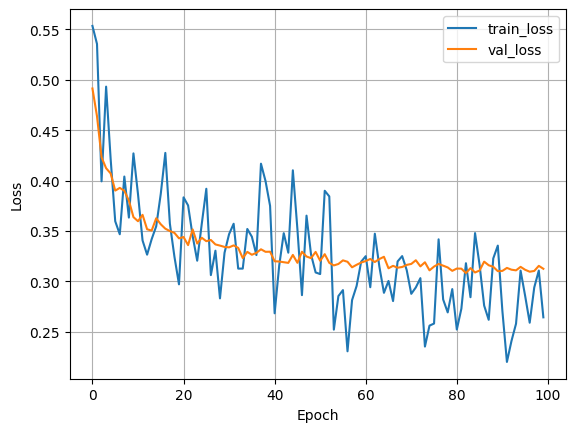

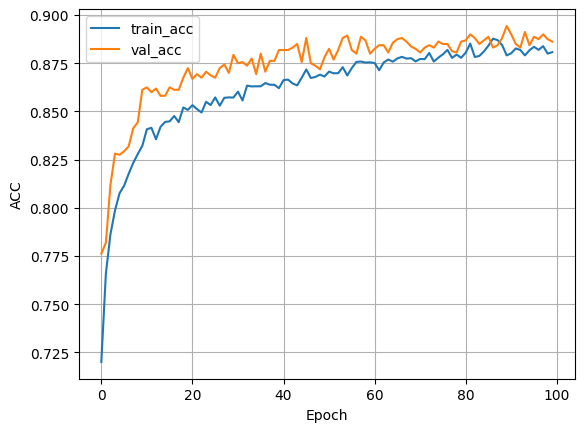

In [6]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

In [56]:
# Performance on test
path = trainer.checkpoint_callback.best_model_path
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader(), ckpt_path=path)
input_string = path

# Find the index of the word "checkpoints" in the string
checkpoints_index = input_string.find("checkpoints")

if checkpoints_index != -1:
    # Extract the substring from the beginning of the input string up to "checkpoints"
    desired_substring = input_string[:checkpoints_index]

    path = desired_substring
else:
    print("The word 'checkpoints' was not found in the input string.")

# Save the test accuracy
with open(f"{path}+test_accuracy.txt", "w") as f:
    f.write(f"test_accuracy: {trainer.callback_metrics['test_acc'].item()}")


Restoring states from the checkpoint path at ./logs\cosine_annealing_lr\version_3\checkpoints\epoch=89-step=40500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs\cosine_annealing_lr\version_3\checkpoints\epoch=89-step=40500.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8857499957084656     │
└───────────────────────────┴───────────────────────────┘

## Debugging methods
### 1. `fast_dev_run`: runs x batch of train to find any bugs. Should return a low accuracy in test.

In [ ]:
trainer = L.Trainer(
    fast_dev_run=3,
    max_epochs = 100,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "cosine_annealing_lr"),
    deterministic = True,
    callbacks = callbacks,
)
trainer.fit(model = lightning_model, datamodule = dm)
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader())

### 2. `overfit_batches`: Overfit a set number of batches. Model should easily reach 100% train accuracy

In [ ]:
trainer = L.Trainer(
    overfit_batches=1
    max_epochs = 100,
    accelerator = "auto",
    devices="auto",
    logger = CSVLogger(save_dir = "./logs", name = "cosine_annealing_lr"),
    deterministic = True,
    callbacks = callbacks,
)
trainer.fit(model = lightning_model, datamodule = dm)
trainer.test(model = lightning_model, dataloaders=dm.test_dataloader())

### 3. Model summary

In [5]:
pytorch_model

PyTorchMLP(
  (all_layers): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=2, bias=True)
  )
)

In [4]:
pytorch_model = PyTorchMLP(num_features = 100, num_classes = 2)
dm = CustomDataModule()
dm.setup("train")
train_dl = dm.train_dataloader()
next(iter(train_dl))[0].shape

In [14]:
#!pip install torchinfo
from torchinfo import summary
# Input size is what is expected in the forward pass i.e, Batch size x Channels x Height x Width
summary(pytorch_model, input_size = [1, 1, 100])

Layer (type:depth-idx)                   Output Shape              Param #
PyTorchMLP                               [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 50]                   5,050
│    └─ReLU: 2-2                         [1, 50]                   --
│    └─Linear: 2-3                       [1, 25]                   1,275
│    └─ReLU: 2-4                         [1, 25]                   --
│    └─Linear: 2-5                       [1, 2]                    52
Total params: 6,377
Trainable params: 6,377
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03